In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [2]:
df  = pd.read_csv("btcusdt.csv", index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.timestamp, unit='ms')
df = df.drop("timestamp", axis=1)
# Cutoff so only looking at 1 yr of training data
df = df[df.index <= '2022-04-01']
df.head()

,exchange,open,high,low,close,volume,instrument,dt
timestamp,,,,,,,,
2021-04-19 00:00:00,binance,56140.05,56237.10,56101.13,56236.48,238.339,BTCUSDT,2021-04-18 17:00:00
2021-04-19 00:01:00,binance,56236.48,56308.34,56236.47,56308.33,267.826,BTCUSDT,2021-04-18 17:01:00
2021-04-19 00:02:00,binance,56308.33,56308.33,56011.00,56011.00,518.377,BTCUSDT,2021-04-18 17:02:00
2021-04-19 00:03:00,binance,56011.01,56055.22,55909.70,55944.27,631.644,BTCUSDT,2021-04-18 17:03:00
2021-04-19 00:04:00,binance,55944.26,56004.50,55901.26,55906.73,194.127,BTCUSDT,2021-04-18 17:04:00


In [3]:
# Only use training data [even days]
df['day_num'] = [df.index[i].day for i in range(len(df))]
df['train_test'] = np.where(df.day_num % 2 == 0, 1, 0)
df = df[df.train_test==1]

df['log_diff'] = np.log(df.high - df.low + 1)
# Target variable is % return for log of 1min [high - low] range
df["log_diff_return"] = (df["log_diff"]-df["log_diff"].shift())/(df["log_diff"].shift()+1)

# Assign the number of minutes since midnight UTC
df['sod_ts'] = [(df.index[i] - df.index[i].replace(hour=0, minute=0)).total_seconds()/60 for i in range(len(df))]
# Assign the minute timestamp per observation
df['mins_hour'] = [df.index[i].minute for i in range(len(df))]
# Assign the hour timestamp per observartion
df['hr_day'] = [df.index[i].hour for i in range(len(df))]

#### Feature Engineering Ideas

- Median return bucketed for each minute of the hour - notice how the log diff return peaks at 0, 15, 30 and 45 minutes. 

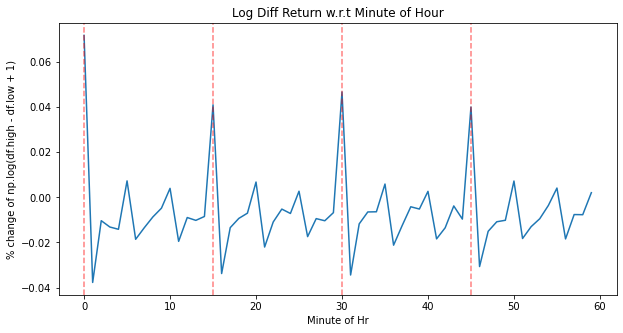

In [4]:
plt.figure(figsize=(10, 5))
s = df.groupby("mins_hour").median()
plt.plot(s.index, s.log_diff_return)
plt.title("Log Diff Return w.r.t Minute of Hour")
plt.ylabel("% change of np.log(df.high - df.low + 1)")
plt.xlabel("Minute of Hr")
plt.axvline(0, linestyle='--', c='r', alpha=0.50)
plt.axvline(15, linestyle='--', c='r', alpha=0.50)
plt.axvline(30, linestyle='--', c='r', alpha=0.50)
plt.axvline(45, linestyle='--', c='r', alpha=0.50)

In [5]:
df[['0min', '15min', '30min', '45min']] = pd.concat([pd.get_dummies(df.mins_hour)[0],
                                                     pd.get_dummies(df.mins_hour)[15],
                                                     pd.get_dummies(df.mins_hour)[30], 
                                                     pd.get_dummies(df.mins_hour)[45]], axis=1)

In [6]:
# pretty weak correlations across the board with this feature
print("0min corr w/ target:", df['0min'].corr(df.log_diff_return))
print("15min corr w/ target:", df['15min'].corr(df.log_diff_return))
print("30min corr w/ target:", df['30min'].corr(df.log_diff_return))
print("45min corr w/ target:", df['45min'].corr(df.log_diff_return))

0min corr w/ target: 0.0760403027284862
15min corr w/ target: 0.04675393658268507
30min corr w/ target: 0.0504456281527516
45min corr w/ target: 0.045656006124448194


- Lagged Log Difference appears to have a decent correlation with the target + normal distribution. The negative correlation makes intuitive sense given that volatility is mean-reverting. 

correlation w/ target variable:  -0.4027704842705828


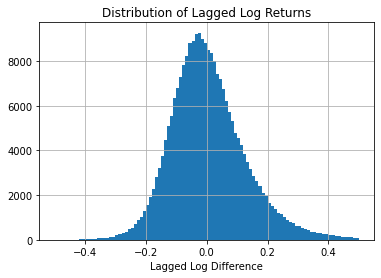

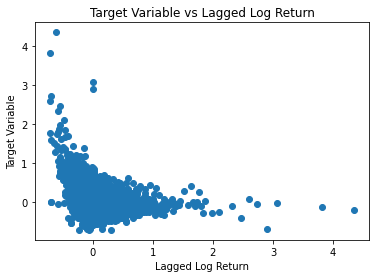

In [7]:
df['lag_log'] = df.log_diff_return.shift(1)
print("correlation w/ target variable: ", df.lag_log.corr(df.log_diff_return));

plt.title("Distribution of Lagged Log Returns")
df.lag_log.hist(bins=100, range=[-0.5, 0.5])
plt.xlabel("Lagged Log Difference")
plt.show()

plt.title("Target Variable vs Lagged Log Return")
plt.scatter(df.lag_log, df.log_diff_return)
plt.xlabel("Lagged Log Return")
plt.ylabel("Target Variable");
plt.show();

- Lagged Log Volume Difference: Similar to above, this feature is also negatively correlated to the target variable (this makes sense because volatility and volume tend to be correlated).

correlation w/ target variable:  -0.24199298383656562


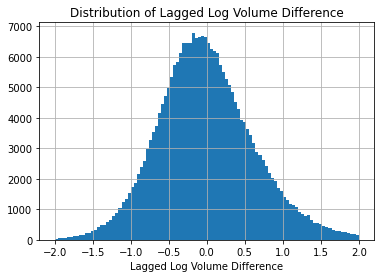

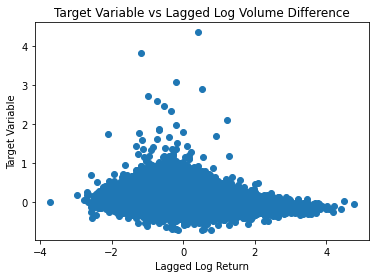

In [8]:
df['volume_diff'] =  np.log(df.volume.shift(1) + 1).diff()
print("correlation w/ target variable: ", df.log_diff_return.corr(df.volume_diff));

plt.title("Distribution of Lagged Log Volume Difference")
df.volume_diff.hist(bins=100, range=[-2, 2])
plt.xlabel("Lagged Log Volume Difference")
plt.show()

plt.title("Target Variable vs Lagged Log Volume Difference")
plt.scatter(df.volume_diff, df.log_diff_return)
plt.xlabel("Lagged Log Return")
plt.ylabel("Target Variable");
plt.show();

- Lagged Log High/Low Difference: Logic is that changes in the high/low will have more of an impact on volatility relative to the open/close. 

log_high corr w/ target variable:  0.07576993382456108
log_low corr w/ target variable:  -0.08978751335845031


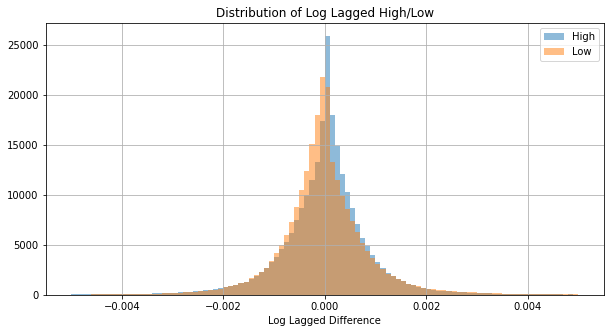

In [9]:
df['log_high'] = np.log(df.low.shift(1)).diff()
df['log_low'] =  np.log(df.high.shift(1)).diff()

# weak correlation - nothing too great
print("log_high corr w/ target variable: ", df.log_high.corr(df.log_diff_return));
print("log_low corr w/ target variable: ", df.log_low.corr(df.log_diff_return));

plt.figure(figsize=(10, 5))
df.log_high.hist(bins=100, range=[-0.005, 0.005], alpha=0.50, label='High')
df.log_low.hist(bins=100, range=[-0.005, 0.005], alpha=0.50, label='Low')

plt.title("Distribution of Log Lagged High/Low")
plt.xlabel("Log Lagged Difference");
plt.legend();

- Hourly Returns: Median return bucketed for each minute of the hour - notice how the log diff peaks at 0, 15, 30 and 45 minutes.

Text(0.5, 0, 'Hr of Day')

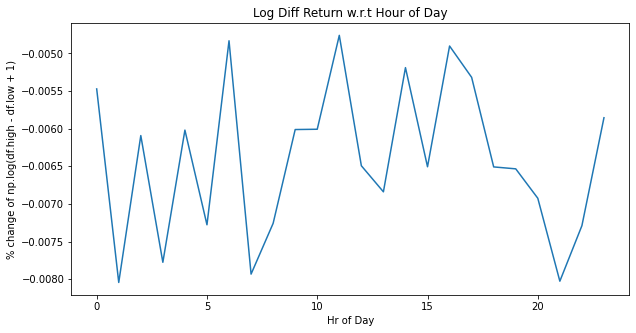

In [10]:
# Notice how tracking the return of the target variable is pretty noisy here
plt.figure(figsize=(10, 5))
s = df.groupby("hr_day").median()
plt.plot(s.index, s.log_diff_return)
plt.title("Log Diff Return w.r.t Hour of Day")
plt.ylabel("% change of np.log(df.high - df.low + 1)")
plt.xlabel("Hr of Day")

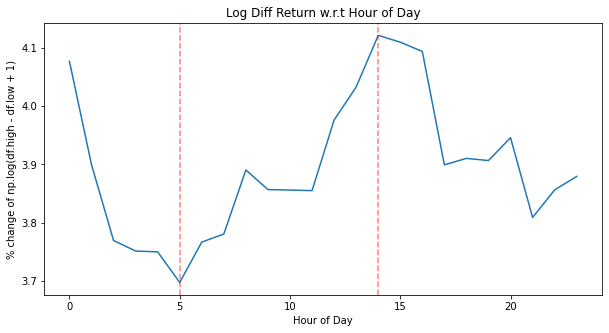

In [11]:
# For that reason we can instead just look at the log_difference [ie: not the % return of target, just target itself]
plt.figure(figsize=(10, 5))
s = df.groupby("hr_day").median()
plt.plot(s.index, s.log_diff)
plt.title("Log Diff Return w.r.t Hour of Day")
plt.ylabel("% change of np.log(df.high - df.low + 1)")
plt.xlabel("Hour of Day")
plt.axvline(5, linestyle='--', c='r', alpha=0.50)
plt.axvline(14, linestyle='--', c='r', alpha=0.50)

In [12]:
df[['hr5', 'hr14']] = pd.concat([pd.get_dummies(df.hr_day)[5],
                                 pd.get_dummies(df.hr_day)[14]], axis=1)

# weak correlation - nothing too great again w/ time-based feature
print("hr5 corr w/ target variable: ", df.hr5.corr(df.log_diff));
print("hr14 corr w/ target variable: ", df.hr14.corr(df.log_diff));

hr5 corr w/ target variable:  -0.05799803167181982
hr14 corr w/ target variable:  0.06514329937271214


- Minutes Since UTC Midnight: Can look at the minutes where the signal is peaked

Text(0.5, 1.0, 'Log Difference [MA15 Smoothed] w.r.t Minutes Since Midnight UTC')

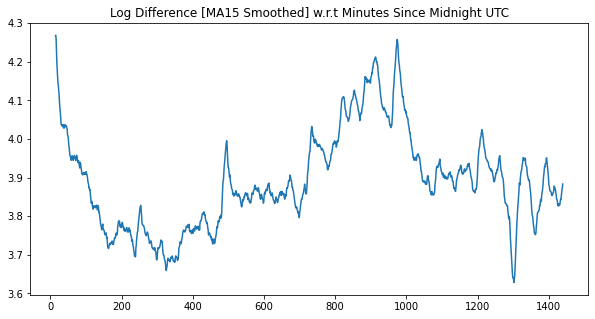

In [13]:
s = df.groupby("sod_ts").median()

# Choosing to smooth out signal by 15 min MA to clean up noise
plt.figure(figsize=(10, 5))
plt.plot(s.log_diff.rolling(15).mean())
plt.title("Log Difference [MA15 Smoothed] w.r.t Minutes Since Midnight UTC")
# This one is a bit too noisy to cleanly include as a feature 

In [14]:
# Add variable of direction of return [will be correlated to other features]
df['direction'] = np.sign(df.log_diff_return).shift(1)

In [15]:
# not including log_high/low - very highly correlated with each other [multicollinearity]
all_columns = ['lag_log', 'volume_diff', '0min', '15min', '30min', '45min',
               'hr5', 'hr14', 'direction', 'log_diff_return']

In [16]:
t = df[all_columns].dropna()
t.head()

,lag_log,volume_diff,0min,15min,30min,45min,hr5,hr14,direction,log_diff_return
timestamp,,,,,,,,,,
2021-04-20 00:02:00,0.019147,-0.444635,0,0,0,0,0,0,1.0,0.078489
2021-04-20 00:03:00,0.078489,1.264528,0,0,0,0,0,0,1.0,-0.087077
2021-04-20 00:04:00,-0.087077,0.036535,0,0,0,0,0,0,-1.0,0.023217
2021-04-20 00:05:00,0.023217,-0.548087,0,0,0,0,0,0,1.0,-0.049115
2021-04-20 00:06:00,-0.049115,0.365437,0,0,0,0,0,0,-1.0,0.035429


In [17]:
y = t.log_diff_return
x = t.iloc[:, :-1]

In [18]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_diff_return   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     5873.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:09:07   Log-Likelihood:             1.7471e+05
No. Observations:              244798   AIC:                        -3.494e+05
Df Residuals:                  244788   BIC:                        -3.493e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0068      0.000     26.001      0.000       0.006       0.007
lag_log        -0.3874      0.003   -126.886      0.000      -0.393      -0.381
volume_diff     0.0076      0.000     15.596      0.000       0.007       0.009
0min            0.0831      0.002     44.385      0.000       0.079       0.087
15min           0.0484      0.002     25.877      0.000       0.045       0.052
30min           0.0552      0.002     29.462      0.000       0.051       0.059
45min           0.0486      0.002     25.947      0.000       0.045       0.052
hr5             0.0017      0.001      1.377      0.169      -0.001       0.004
hr14           -0.0021      0.001     -1.738      0.082      -0.004       0.000
direction      -0.0071      0.000    -19.735      0.000      -0.008      -0.006
==============================================================================
Omnibus:                   107148.791   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3887336.968
Skew:                           1.447   Prob(JB):                         0.00
Kurtosis:                      22.306   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
predict = np.sign(model.predict())
actual = np.sign(y)

# 64% prediction accuracy on the side [IN-SAMPLE results]
((predict==actual).sum() / len(predict))*100

64.2002794140475

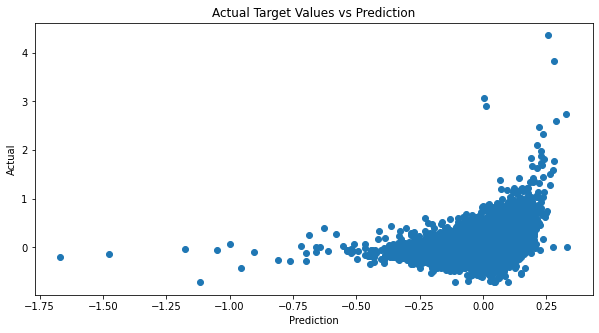

In [20]:
plt.figure(figsize=(10, 5))
plt.title("Actual Target Values vs Prediction")
plt.scatter(model.predict(), y)
plt.xlabel("Prediction")
plt.ylabel("Actual");